In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Umpire", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Umpire", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Umpire", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['Four', 'Leg_Bye', 'No_ball', 'Out', 'Six', 'Wide']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)

Total training images: 1728
Total validation images: 468
Total test images: 585
Total images in dataset: 2781


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))

Training images (excluding 'random_occlusion'): 1536
Validation images (excluding 'random_occlusion'): 416
Test images (excluding 'random_occlusion'): 520
Total images (excluding 'random_occlusion'): 2472


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'original', 'blur', 'dirty_lens', 'chromatic_aberration', 'lens_flare', 'random_occlusion', 'low_resolution', 'motion_blur', 'gaussian_noise'}
Validation folders considered: {'original', 'blur', 'dirty_lens', 'chromatic_aberration', 'lens_flare', 'random_occlusion', 'low_resolution', 'motion_blur', 'gaussian_noise'}
Test folders considered: {'original', 'blur', 'dirty_lens', 'chromatic_aberration', 'lens_flare', 'random_occlusion', 'low_resolution', 'motion_blur', 'gaussian_noise'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Umpire", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Umpire", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Umpire", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))

Classes: ['Four', 'Leg_Bye', 'No_ball', 'Out', 'Six', 'Wide']
Final Training images: 1536
Final Validation images: 416
Final Test images: 520
Total images after filtering: 2472


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'original', 'blur', 'dirty_lens', 'chromatic_aberration', 'lens_flare', 'low_resolution', 'motion_blur', 'gaussian_noise'}
Validation folders considered: {'original', 'blur', 'dirty_lens', 'chromatic_aberration', 'lens_flare', 'low_resolution', 'motion_blur', 'gaussian_noise'}
Test folders considered: {'original', 'blur', 'dirty_lens', 'chromatic_aberration', 'lens_flare', 'low_resolution', 'motion_blur', 'gaussian_noise'}


In [7]:
# -----------------------------
# 2. Define DenseNet-121 Model from Scratch
# -----------------------------

class DenseLayer(nn.Module):
    """Single Dense Layer: BN-ReLU-Conv(1x1)-BN-ReLU-Conv(3x3)"""
    def __init__(self, in_channels, growth_rate=32, bn_size=4):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, bn_size * growth_rate, 
                              kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, 
                              kernel_size=3, padding=1, bias=False)
        
    def forward(self, x):
        # First convolution block
        out = F.relu(self.bn1(x))
        out = self.conv1(out)
        
        # Second convolution block
        out = F.relu(self.bn2(out))
        out = self.conv2(out)
        
        # Concatenate input with output (dense connection)
        return torch.cat([x, out], 1)

class DenseBlock(nn.Module):
    """Dense Block containing multiple Dense Layers"""
    def __init__(self, num_layers, in_channels, growth_rate=32, bn_size=4):
        super().__init__()
        self.layers = nn.ModuleList()
        
        for i in range(num_layers):
            layer = DenseLayer(in_channels + i * growth_rate, growth_rate, bn_size)
            self.layers.append(layer)
            
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class TransitionLayer(nn.Module):
    """Transition Layer: BN-ReLU-Conv(1x1)-AvgPool(2x2)"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        out = F.relu(self.bn(x))
        out = self.conv(out)
        out = self.pool(out)
        return out

class MyDenseNet121(nn.Module):
    """DenseNet-121 Implementation from Scratch"""
    def __init__(self, in_channels=3, classes=4, growth_rate=32, 
                 block_config=[6, 12, 24, 16], bn_size=4, compression_rate=0.5):
        super().__init__()
        
        # Initial convolution layer
        self.initial_conv = nn.Conv2d(in_channels, 64, kernel_size=7, 
                                     stride=2, padding=3, bias=False)
        self.initial_bn = nn.BatchNorm2d(64)
        self.initial_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Dense blocks and transition layers
        num_features = 64
        
        # Dense Block 1 + Transition 1
        self.dense_block1 = DenseBlock(block_config[0], num_features, growth_rate, bn_size)
        num_features += block_config[0] * growth_rate
        out_features = int(num_features * compression_rate)
        self.transition1 = TransitionLayer(num_features, out_features)
        num_features = out_features
        
        # Dense Block 2 + Transition 2
        self.dense_block2 = DenseBlock(block_config[1], num_features, growth_rate, bn_size)
        num_features += block_config[1] * growth_rate
        out_features = int(num_features * compression_rate)
        self.transition2 = TransitionLayer(num_features, out_features)
        num_features = out_features
        
        # Dense Block 3 + Transition 3
        self.dense_block3 = DenseBlock(block_config[2], num_features, growth_rate, bn_size)
        num_features += block_config[2] * growth_rate
        out_features = int(num_features * compression_rate)
        self.transition3 = TransitionLayer(num_features, out_features)
        num_features = out_features
        
        # Dense Block 4 (no transition after last block)
        self.dense_block4 = DenseBlock(block_config[3], num_features, growth_rate, bn_size)
        num_features += block_config[3] * growth_rate
        
        # Final layers
        self.final_bn = nn.BatchNorm2d(num_features)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(num_features, classes)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using He initialization for conv layers"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Initial convolution and pooling
        x = self.initial_conv(x)
        x = F.relu(self.initial_bn(x))
        x = self.initial_pool(x)
        
        # Dense blocks with transitions
        x = self.dense_block1(x)
        x = self.transition1(x)
        
        x = self.dense_block2(x)
        x = self.transition2(x)
        
        x = self.dense_block3(x)
        x = self.transition3(x)
        
        x = self.dense_block4(x)
        
        # Final classification layers
        x = F.relu(self.final_bn(x))
        x = self.global_pool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        
        return x

# -----------------------------
# 3. Training Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyDenseNet121(3, classes=len(classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("DenseNet-121 Model Summary:")
summary(model, (3, 224, 224))

DenseNet-121 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         MaxPool2d-3           [-1, 64, 56, 56]               0
       BatchNorm2d-4           [-1, 64, 56, 56]             128
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
            Conv2d-7           [-1, 32, 56, 56]          36,864
        DenseLayer-8           [-1, 96, 56, 56]               0
       BatchNorm2d-9           [-1, 96, 56, 56]             192
           Conv2d-10          [-1, 128, 56, 56]          12,288
      BatchNorm2d-11          [-1, 128, 56, 56]             256
           Conv2d-12           [-1, 32, 56, 56]          36,864
       DenseLayer-13          [-1, 128, 56, 56]               0
      Batch


🚀 Starting DenseNet-121 Training for 50 epochs...

📈 Epoch 1/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:31<00:00,  1.55it/s, Loss=1.5602, Acc=0.3639]


✅ Training completed in 31.01s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:05<00:00,  2.54it/s, Loss=1.8142, Acc=0.3365]


✅ Validation completed in 5.12s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.3365

📊 Epoch 1 Summary:
│ Train Loss: 1.5602 | Train Acc: 0.3639
│ Val Loss:   1.8142 | Val Acc:   0.3365
│ Train Time: 31.01s | Val Time: 5.12s
│ Total Epoch Time: 36.14s
│ Best Val Acc: 0.3365 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 2/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:24<00:00,  1.96it/s, Loss=1.4089, Acc=0.4199]


✅ Training completed in 24.53s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.58it/s, Loss=1.6472, Acc=0.3678]


✅ Validation completed in 3.64s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.3678

📊 Epoch 2 Summary:
│ Train Loss: 1.4089 | Train Acc: 0.4199
│ Val Loss:   1.6472 | Val Acc:   0.3678
│ Train Time: 24.53s | Val Time: 3.64s
│ Total Epoch Time: 28.18s
│ Best Val Acc: 0.3678 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 3/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:24<00:00,  1.95it/s, Loss=1.2584, Acc=0.5052]


✅ Training completed in 24.64s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.57it/s, Loss=1.8113, Acc=0.3654]


✅ Validation completed in 3.64s

📊 Epoch 3 Summary:
│ Train Loss: 1.2584 | Train Acc: 0.5052
│ Val Loss:   1.8113 | Val Acc:   0.3654
│ Train Time: 24.64s | Val Time: 3.64s
│ Total Epoch Time: 28.28s
│ Best Val Acc: 0.3678 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 4/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:24<00:00,  1.93it/s, Loss=1.1496, Acc=0.5469]


✅ Training completed in 24.84s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.58it/s, Loss=2.1481, Acc=0.3269]


✅ Validation completed in 3.64s

📊 Epoch 4 Summary:
│ Train Loss: 1.1496 | Train Acc: 0.5469
│ Val Loss:   2.1481 | Val Acc:   0.3269
│ Train Time: 24.84s | Val Time: 3.64s
│ Total Epoch Time: 28.48s
│ Best Val Acc: 0.3678 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 5/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:24<00:00,  1.93it/s, Loss=0.8913, Acc=0.6628]


✅ Training completed in 24.83s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.62it/s, Loss=2.2889, Acc=0.3678]


✅ Validation completed in 3.59s

📊 Epoch 5 Summary:
│ Train Loss: 0.8913 | Train Acc: 0.6628
│ Val Loss:   2.2889 | Val Acc:   0.3678
│ Train Time: 24.83s | Val Time: 3.59s
│ Total Epoch Time: 28.42s
│ Best Val Acc: 0.3678 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 6/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:24<00:00,  1.93it/s, Loss=0.8016, Acc=0.7064]


✅ Training completed in 24.82s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.55it/s, Loss=2.4726, Acc=0.3918]


✅ Validation completed in 3.66s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.3918

📊 Epoch 6 Summary:
│ Train Loss: 0.8016 | Train Acc: 0.7064
│ Val Loss:   2.4726 | Val Acc:   0.3918
│ Train Time: 24.82s | Val Time: 3.66s
│ Total Epoch Time: 28.50s
│ Best Val Acc: 0.3918 (Epoch 6)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 7/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:24<00:00,  1.93it/s, Loss=0.6904, Acc=0.7461]


✅ Training completed in 24.89s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.60it/s, Loss=1.8107, Acc=0.4135]


✅ Validation completed in 3.62s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.4135

📊 Epoch 7 Summary:
│ Train Loss: 0.6904 | Train Acc: 0.7461
│ Val Loss:   1.8107 | Val Acc:   0.4135
│ Train Time: 24.89s | Val Time: 3.62s
│ Total Epoch Time: 28.51s
│ Best Val Acc: 0.4135 (Epoch 7)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 8/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:24<00:00,  1.92it/s, Loss=0.4396, Acc=0.8411]


✅ Training completed in 24.95s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.50it/s, Loss=1.9795, Acc=0.5361]


✅ Validation completed in 3.72s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.5361

📊 Epoch 8 Summary:
│ Train Loss: 0.4396 | Train Acc: 0.8411
│ Val Loss:   1.9795 | Val Acc:   0.5361
│ Train Time: 24.95s | Val Time: 3.72s
│ Total Epoch Time: 28.68s
│ Best Val Acc: 0.5361 (Epoch 8)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 9/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:24<00:00,  1.92it/s, Loss=0.3428, Acc=0.8848]


✅ Training completed in 24.97s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.66it/s, Loss=1.7818, Acc=0.4976]


✅ Validation completed in 3.56s

📊 Epoch 9 Summary:
│ Train Loss: 0.3428 | Train Acc: 0.8848
│ Val Loss:   1.7818 | Val Acc:   0.4976
│ Train Time: 24.97s | Val Time: 3.56s
│ Total Epoch Time: 28.53s
│ Best Val Acc: 0.5361 (Epoch 8)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 10/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:24<00:00,  1.93it/s, Loss=0.2909, Acc=0.8893]


✅ Training completed in 24.91s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.60it/s, Loss=1.8572, Acc=0.4880]


✅ Validation completed in 3.62s

📊 Epoch 10 Summary:
│ Train Loss: 0.2909 | Train Acc: 0.8893
│ Val Loss:   1.8572 | Val Acc:   0.4880
│ Train Time: 24.91s | Val Time: 3.62s
│ Total Epoch Time: 28.54s
│ Best Val Acc: 0.5361 (Epoch 8)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 11/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.91it/s, Loss=0.2413, Acc=0.9167]


✅ Training completed in 25.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.65it/s, Loss=2.5464, Acc=0.4471]


✅ Validation completed in 3.56s

📊 Epoch 11 Summary:
│ Train Loss: 0.2413 | Train Acc: 0.9167
│ Val Loss:   2.5464 | Val Acc:   0.4471
│ Train Time: 25.19s | Val Time: 3.56s
│ Total Epoch Time: 28.76s
│ Best Val Acc: 0.5361 (Epoch 8)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 12/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:24<00:00,  1.92it/s, Loss=0.2053, Acc=0.9310]


✅ Training completed in 24.99s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.67it/s, Loss=2.7028, Acc=0.4399]


✅ Validation completed in 3.55s

📊 Epoch 12 Summary:
│ Train Loss: 0.2053 | Train Acc: 0.9310
│ Val Loss:   2.7028 | Val Acc:   0.4399
│ Train Time: 24.99s | Val Time: 3.55s
│ Total Epoch Time: 28.54s
│ Best Val Acc: 0.5361 (Epoch 8)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 13/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.91it/s, Loss=0.1500, Acc=0.9583]


✅ Training completed in 25.20s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.55it/s, Loss=2.6366, Acc=0.4712]


✅ Validation completed in 3.66s

📊 Epoch 13 Summary:
│ Train Loss: 0.1500 | Train Acc: 0.9583
│ Val Loss:   2.6366 | Val Acc:   0.4712
│ Train Time: 25.20s | Val Time: 3.66s
│ Total Epoch Time: 28.87s
│ Best Val Acc: 0.5361 (Epoch 8)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 14/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.91it/s, Loss=0.1464, Acc=0.9512]


✅ Training completed in 25.17s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.55it/s, Loss=2.1900, Acc=0.5216]


✅ Validation completed in 3.66s

📊 Epoch 14 Summary:
│ Train Loss: 0.1464 | Train Acc: 0.9512
│ Val Loss:   2.1900 | Val Acc:   0.5216
│ Train Time: 25.17s | Val Time: 3.66s
│ Total Epoch Time: 28.84s
│ Best Val Acc: 0.5361 (Epoch 8)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 15/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.91it/s, Loss=0.1050, Acc=0.9629]


✅ Training completed in 25.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.62it/s, Loss=2.6645, Acc=0.4976]


✅ Validation completed in 3.59s

📊 Epoch 15 Summary:
│ Train Loss: 0.1050 | Train Acc: 0.9629
│ Val Loss:   2.6645 | Val Acc:   0.4976
│ Train Time: 25.18s | Val Time: 3.59s
│ Total Epoch Time: 28.77s
│ Best Val Acc: 0.5361 (Epoch 8)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 16/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.91it/s, Loss=0.1248, Acc=0.9525]


✅ Training completed in 25.15s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.44it/s, Loss=2.0280, Acc=0.5529]


✅ Validation completed in 3.79s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.5529

📊 Epoch 16 Summary:
│ Train Loss: 0.1248 | Train Acc: 0.9525
│ Val Loss:   2.0280 | Val Acc:   0.5529
│ Train Time: 25.15s | Val Time: 3.79s
│ Total Epoch Time: 28.95s
│ Best Val Acc: 0.5529 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 17/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.90it/s, Loss=0.1074, Acc=0.9603]


✅ Training completed in 25.23s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.66it/s, Loss=2.2795, Acc=0.5216]


✅ Validation completed in 3.56s

📊 Epoch 17 Summary:
│ Train Loss: 0.1074 | Train Acc: 0.9603
│ Val Loss:   2.2795 | Val Acc:   0.5216
│ Train Time: 25.23s | Val Time: 3.56s
│ Total Epoch Time: 28.79s
│ Best Val Acc: 0.5529 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 18/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:24<00:00,  1.92it/s, Loss=0.1161, Acc=0.9635]


✅ Training completed in 24.99s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.54it/s, Loss=2.5484, Acc=0.4928]


✅ Validation completed in 3.68s

📊 Epoch 18 Summary:
│ Train Loss: 0.1161 | Train Acc: 0.9635
│ Val Loss:   2.5484 | Val Acc:   0.4928
│ Train Time: 24.99s | Val Time: 3.68s
│ Total Epoch Time: 28.67s
│ Best Val Acc: 0.5529 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 19/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.91it/s, Loss=0.0726, Acc=0.9772]


✅ Training completed in 25.10s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.66it/s, Loss=2.5279, Acc=0.5312]


✅ Validation completed in 3.55s

📊 Epoch 19 Summary:
│ Train Loss: 0.0726 | Train Acc: 0.9772
│ Val Loss:   2.5279 | Val Acc:   0.5312
│ Train Time: 25.10s | Val Time: 3.55s
│ Total Epoch Time: 28.65s
│ Best Val Acc: 0.5529 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 20/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:24<00:00,  1.93it/s, Loss=0.0591, Acc=0.9818]


✅ Training completed in 24.92s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.60it/s, Loss=2.0811, Acc=0.6442]


✅ Validation completed in 3.61s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.6442

📊 Epoch 20 Summary:
│ Train Loss: 0.0591 | Train Acc: 0.9818
│ Val Loss:   2.0811 | Val Acc:   0.6442
│ Train Time: 24.92s | Val Time: 3.61s
│ Total Epoch Time: 28.54s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 21/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.90it/s, Loss=0.0429, Acc=0.9889]


✅ Training completed in 25.24s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.65it/s, Loss=2.2454, Acc=0.5601]


✅ Validation completed in 3.56s

📊 Epoch 21 Summary:
│ Train Loss: 0.0429 | Train Acc: 0.9889
│ Val Loss:   2.2454 | Val Acc:   0.5601
│ Train Time: 25.24s | Val Time: 3.56s
│ Total Epoch Time: 28.81s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 22/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.92it/s, Loss=0.0354, Acc=0.9870]


✅ Training completed in 25.04s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.55it/s, Loss=2.2159, Acc=0.5288]


✅ Validation completed in 3.67s

📊 Epoch 22 Summary:
│ Train Loss: 0.0354 | Train Acc: 0.9870
│ Val Loss:   2.2159 | Val Acc:   0.5288
│ Train Time: 25.04s | Val Time: 3.67s
│ Total Epoch Time: 28.71s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 23/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.91it/s, Loss=0.0451, Acc=0.9811]


✅ Training completed in 25.13s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.61it/s, Loss=2.5258, Acc=0.5769]


✅ Validation completed in 3.60s

📊 Epoch 23 Summary:
│ Train Loss: 0.0451 | Train Acc: 0.9811
│ Val Loss:   2.5258 | Val Acc:   0.5769
│ Train Time: 25.13s | Val Time: 3.60s
│ Total Epoch Time: 28.74s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 24/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:24<00:00,  1.92it/s, Loss=0.0777, Acc=0.9772]


✅ Training completed in 24.98s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.53it/s, Loss=2.4782, Acc=0.4832]


✅ Validation completed in 3.68s

📊 Epoch 24 Summary:
│ Train Loss: 0.0777 | Train Acc: 0.9772
│ Val Loss:   2.4782 | Val Acc:   0.4832
│ Train Time: 24.98s | Val Time: 3.68s
│ Total Epoch Time: 28.67s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 25/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.91it/s, Loss=0.0649, Acc=0.9759]


✅ Training completed in 25.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.62it/s, Loss=2.3293, Acc=0.5673]


✅ Validation completed in 3.60s

📊 Epoch 25 Summary:
│ Train Loss: 0.0649 | Train Acc: 0.9759
│ Val Loss:   2.3293 | Val Acc:   0.5673
│ Train Time: 25.19s | Val Time: 3.60s
│ Total Epoch Time: 28.80s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 26/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.91it/s, Loss=0.0710, Acc=0.9779]


✅ Training completed in 25.16s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.68it/s, Loss=2.0979, Acc=0.5553]


✅ Validation completed in 3.54s

📊 Epoch 26 Summary:
│ Train Loss: 0.0710 | Train Acc: 0.9779
│ Val Loss:   2.0979 | Val Acc:   0.5553
│ Train Time: 25.16s | Val Time: 3.54s
│ Total Epoch Time: 28.70s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 27/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.90it/s, Loss=0.0559, Acc=0.9779]


✅ Training completed in 25.26s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.60it/s, Loss=1.9900, Acc=0.6274]


✅ Validation completed in 3.61s

📊 Epoch 27 Summary:
│ Train Loss: 0.0559 | Train Acc: 0.9779
│ Val Loss:   1.9900 | Val Acc:   0.6274
│ Train Time: 25.26s | Val Time: 3.61s
│ Total Epoch Time: 28.88s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 28/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.90it/s, Loss=0.0182, Acc=0.9948]


✅ Training completed in 25.30s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.57it/s, Loss=2.0077, Acc=0.6058]


✅ Validation completed in 3.64s

📊 Epoch 28 Summary:
│ Train Loss: 0.0182 | Train Acc: 0.9948
│ Val Loss:   2.0077 | Val Acc:   0.6058
│ Train Time: 25.30s | Val Time: 3.64s
│ Total Epoch Time: 28.95s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 29/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.91it/s, Loss=0.0266, Acc=0.9896]


✅ Training completed in 25.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.46it/s, Loss=2.4458, Acc=0.5889]


✅ Validation completed in 3.76s

📊 Epoch 29 Summary:
│ Train Loss: 0.0266 | Train Acc: 0.9896
│ Val Loss:   2.4458 | Val Acc:   0.5889
│ Train Time: 25.19s | Val Time: 3.76s
│ Total Epoch Time: 28.95s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 30/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.90it/s, Loss=0.0526, Acc=0.9844]


✅ Training completed in 25.33s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.67it/s, Loss=2.6550, Acc=0.5409]


✅ Validation completed in 3.54s

📊 Epoch 30 Summary:
│ Train Loss: 0.0526 | Train Acc: 0.9844
│ Val Loss:   2.6550 | Val Acc:   0.5409
│ Train Time: 25.33s | Val Time: 3.54s
│ Total Epoch Time: 28.87s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 31/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.90it/s, Loss=0.0713, Acc=0.9759]


✅ Training completed in 25.22s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.56it/s, Loss=2.8714, Acc=0.5409]


✅ Validation completed in 3.65s

📊 Epoch 31 Summary:
│ Train Loss: 0.0713 | Train Acc: 0.9759
│ Val Loss:   2.8714 | Val Acc:   0.5409
│ Train Time: 25.22s | Val Time: 3.65s
│ Total Epoch Time: 28.88s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 32/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.90it/s, Loss=0.0321, Acc=0.9876]


✅ Training completed in 25.29s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.63it/s, Loss=2.4253, Acc=0.5962]


✅ Validation completed in 3.58s

📊 Epoch 32 Summary:
│ Train Loss: 0.0321 | Train Acc: 0.9876
│ Val Loss:   2.4253 | Val Acc:   0.5962
│ Train Time: 25.29s | Val Time: 3.58s
│ Total Epoch Time: 28.88s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 33/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.92it/s, Loss=0.0402, Acc=0.9883]


✅ Training completed in 25.02s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.64it/s, Loss=3.2076, Acc=0.4784]


✅ Validation completed in 3.57s

📊 Epoch 33 Summary:
│ Train Loss: 0.0402 | Train Acc: 0.9883
│ Val Loss:   3.2076 | Val Acc:   0.4784
│ Train Time: 25.02s | Val Time: 3.57s
│ Total Epoch Time: 28.60s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 34/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.91it/s, Loss=0.0361, Acc=0.9831]


✅ Training completed in 25.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.59it/s, Loss=2.5113, Acc=0.5865]


✅ Validation completed in 3.63s

📊 Epoch 34 Summary:
│ Train Loss: 0.0361 | Train Acc: 0.9831
│ Val Loss:   2.5113 | Val Acc:   0.5865
│ Train Time: 25.19s | Val Time: 3.63s
│ Total Epoch Time: 28.82s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 35/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.91it/s, Loss=0.0437, Acc=0.9863]


✅ Training completed in 25.10s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.67it/s, Loss=2.6687, Acc=0.5216]


✅ Validation completed in 3.54s

📊 Epoch 35 Summary:
│ Train Loss: 0.0437 | Train Acc: 0.9863
│ Val Loss:   2.6687 | Val Acc:   0.5216
│ Train Time: 25.10s | Val Time: 3.54s
│ Total Epoch Time: 28.65s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 36/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.91it/s, Loss=0.0796, Acc=0.9727]


✅ Training completed in 25.07s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.68it/s, Loss=2.7931, Acc=0.5457]


✅ Validation completed in 3.53s

📊 Epoch 36 Summary:
│ Train Loss: 0.0796 | Train Acc: 0.9727
│ Val Loss:   2.7931 | Val Acc:   0.5457
│ Train Time: 25.07s | Val Time: 3.53s
│ Total Epoch Time: 28.61s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 37/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.90it/s, Loss=0.0436, Acc=0.9831]


✅ Training completed in 25.22s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.61it/s, Loss=2.6522, Acc=0.5216]


✅ Validation completed in 3.61s

📊 Epoch 37 Summary:
│ Train Loss: 0.0436 | Train Acc: 0.9831
│ Val Loss:   2.6522 | Val Acc:   0.5216
│ Train Time: 25.22s | Val Time: 3.61s
│ Total Epoch Time: 28.83s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 38/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.89it/s, Loss=0.0342, Acc=0.9889]


✅ Training completed in 25.40s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.68it/s, Loss=2.4336, Acc=0.6370]


✅ Validation completed in 3.53s

📊 Epoch 38 Summary:
│ Train Loss: 0.0342 | Train Acc: 0.9889
│ Val Loss:   2.4336 | Val Acc:   0.6370
│ Train Time: 25.40s | Val Time: 3.53s
│ Total Epoch Time: 28.94s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 39/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:24<00:00,  1.92it/s, Loss=0.0445, Acc=0.9850]


✅ Training completed in 24.99s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.50it/s, Loss=2.1181, Acc=0.5913]


✅ Validation completed in 3.72s

📊 Epoch 39 Summary:
│ Train Loss: 0.0445 | Train Acc: 0.9850
│ Val Loss:   2.1181 | Val Acc:   0.5913
│ Train Time: 24.99s | Val Time: 3.72s
│ Total Epoch Time: 28.71s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 40/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.91it/s, Loss=0.0190, Acc=0.9922]


✅ Training completed in 25.07s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.62it/s, Loss=2.9800, Acc=0.6010]


✅ Validation completed in 3.59s

📊 Epoch 40 Summary:
│ Train Loss: 0.0190 | Train Acc: 0.9922
│ Val Loss:   2.9800 | Val Acc:   0.6010
│ Train Time: 25.07s | Val Time: 3.59s
│ Total Epoch Time: 28.67s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 41/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.92it/s, Loss=0.0240, Acc=0.9935]


✅ Training completed in 25.07s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.61it/s, Loss=2.8125, Acc=0.5962]


✅ Validation completed in 3.60s

📊 Epoch 41 Summary:
│ Train Loss: 0.0240 | Train Acc: 0.9935
│ Val Loss:   2.8125 | Val Acc:   0.5962
│ Train Time: 25.07s | Val Time: 3.60s
│ Total Epoch Time: 28.67s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 42/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:24<00:00,  1.92it/s, Loss=0.0505, Acc=0.9850]


✅ Training completed in 24.97s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.61it/s, Loss=3.0069, Acc=0.5793]


✅ Validation completed in 3.61s

📊 Epoch 42 Summary:
│ Train Loss: 0.0505 | Train Acc: 0.9850
│ Val Loss:   3.0069 | Val Acc:   0.5793
│ Train Time: 24.97s | Val Time: 3.61s
│ Total Epoch Time: 28.58s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 43/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.92it/s, Loss=0.0166, Acc=0.9948]


✅ Training completed in 25.01s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.62it/s, Loss=2.0476, Acc=0.5577]


✅ Validation completed in 3.59s

📊 Epoch 43 Summary:
│ Train Loss: 0.0166 | Train Acc: 0.9948
│ Val Loss:   2.0476 | Val Acc:   0.5577
│ Train Time: 25.01s | Val Time: 3.59s
│ Total Epoch Time: 28.60s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 44/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.92it/s, Loss=0.0041, Acc=0.9993]


✅ Training completed in 25.07s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.65it/s, Loss=2.3401, Acc=0.6154]


✅ Validation completed in 3.57s

📊 Epoch 44 Summary:
│ Train Loss: 0.0041 | Train Acc: 0.9993
│ Val Loss:   2.3401 | Val Acc:   0.6154
│ Train Time: 25.07s | Val Time: 3.57s
│ Total Epoch Time: 28.64s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 45/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.91it/s, Loss=0.0024, Acc=0.9993]


✅ Training completed in 25.08s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.66it/s, Loss=2.5875, Acc=0.6202]


✅ Validation completed in 3.55s

📊 Epoch 45 Summary:
│ Train Loss: 0.0024 | Train Acc: 0.9993
│ Val Loss:   2.5875 | Val Acc:   0.6202
│ Train Time: 25.08s | Val Time: 3.55s
│ Total Epoch Time: 28.64s
│ Best Val Acc: 0.6442 (Epoch 20)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 46/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.92it/s, Loss=0.0017, Acc=1.0000]


✅ Training completed in 25.02s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.55it/s, Loss=2.1381, Acc=0.6466]


✅ Validation completed in 3.66s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.6466

📊 Epoch 46 Summary:
│ Train Loss: 0.0017 | Train Acc: 1.0000
│ Val Loss:   2.1381 | Val Acc:   0.6466
│ Train Time: 25.02s | Val Time: 3.66s
│ Total Epoch Time: 28.69s
│ Best Val Acc: 0.6466 (Epoch 46)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 47/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.90it/s, Loss=0.0010, Acc=1.0000]


✅ Training completed in 25.33s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.60it/s, Loss=2.1308, Acc=0.6418]


✅ Validation completed in 3.61s

📊 Epoch 47 Summary:
│ Train Loss: 0.0010 | Train Acc: 1.0000
│ Val Loss:   2.1308 | Val Acc:   0.6418
│ Train Time: 25.33s | Val Time: 3.61s
│ Total Epoch Time: 28.95s
│ Best Val Acc: 0.6466 (Epoch 46)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 48/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.92it/s, Loss=0.0015, Acc=1.0000]


✅ Training completed in 25.03s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.54it/s, Loss=2.4508, Acc=0.6154]


✅ Validation completed in 3.68s

📊 Epoch 48 Summary:
│ Train Loss: 0.0015 | Train Acc: 1.0000
│ Val Loss:   2.4508 | Val Acc:   0.6154
│ Train Time: 25.03s | Val Time: 3.68s
│ Total Epoch Time: 28.72s
│ Best Val Acc: 0.6466 (Epoch 46)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 49/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.92it/s, Loss=0.0011, Acc=1.0000]


✅ Training completed in 25.02s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.60it/s, Loss=2.3510, Acc=0.6178]


✅ Validation completed in 3.61s

📊 Epoch 49 Summary:
│ Train Loss: 0.0011 | Train Acc: 1.0000
│ Val Loss:   2.3510 | Val Acc:   0.6178
│ Train Time: 25.02s | Val Time: 3.61s
│ Total Epoch Time: 28.63s
│ Best Val Acc: 0.6466 (Epoch 46)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 50/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.91it/s, Loss=0.0005, Acc=1.0000]


✅ Training completed in 25.07s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:03<00:00,  3.60it/s, Loss=2.4650, Acc=0.6106]


✅ Validation completed in 3.61s

📊 Epoch 50 Summary:
│ Train Loss: 0.0005 | Train Acc: 1.0000
│ Val Loss:   2.4650 | Val Acc:   0.6106
│ Train Time: 25.07s | Val Time: 3.61s
│ Total Epoch Time: 28.68s
│ Best Val Acc: 0.6466 (Epoch 46)
│ GPU Memory: 0.1GB / 4.5GB

💾 Best DenseNet-121 model saved as 'best_densenet121_model.pth'
📊 Best model stats:
│ Best Epoch: 46
│ Best Val Acc: 0.6466

💾 DenseNet-121 training history saved to 'densenet121_training_history.csv'

🎉 DenseNet-121 Training Complete!
Total Training Time: 1442.13s (24.0 minutes)
Average Epoch Time: 28.84s

⏱️  Epoch Timing Breakdown:
│ Epoch 1: 36.14s
│ Epoch 2: 28.18s
│ Epoch 3: 28.28s
│ Epoch 4: 28.48s
│ Epoch 5: 28.42s
│ Epoch 6: 28.50s
│ Epoch 7: 28.51s
│ Epoch 8: 28.68s
│ Epoch 9: 28.53s
│ Epoch 10: 28.54s
│ Epoch 11: 28.76s
│ Epoch 12: 28.54s
│ Epoch 13: 28.87s
│ Epoch 14: 28.84s
│ Epoch 15: 28.77s
│ Epoch 16: 28.95s
│ Epoch 17: 28.79s
│ Epoch 18: 28.67s
│ Epoch 19: 28.65s
│ Epoch 20: 28.54s
│ Epoch 21: 28.81s
│ Epoch 2

Testing DenseNet-121: 100%|██████████████████████████████| 17/17 [00:06<00:00,  2.62it/s]


✅ DenseNet-121 Testing completed in 6.49s

📋 DenseNet-121 Classification Report:
              precision    recall  f1-score   support

        Four       0.00      0.00      0.00        40
     Leg_Bye       0.60      0.23      0.33        40
     No_ball       0.50      0.52      0.51       104
         Out       0.55      0.62      0.58        48
         Six       0.67      0.67      0.67       152
        Wide       0.55      0.62      0.58       136

    accuracy                           0.54       520
   macro avg       0.48      0.44      0.45       520
weighted avg       0.54      0.54      0.53       520

🎯 DenseNet-121 Test Accuracy: 0.5365

📊 DenseNet-121 Model Performance Summary:
│ Best Validation Acc:  0.6466 (Epoch 46)
│ Final Test Accuracy:  0.5365
│ Val-Test Gap:         0.1101


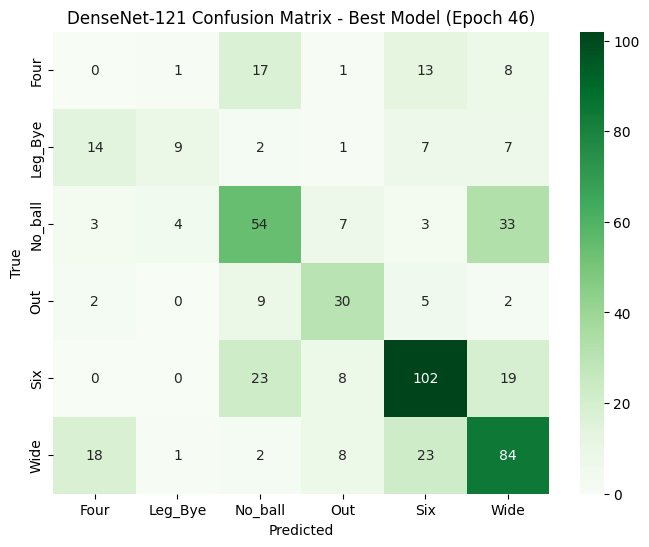

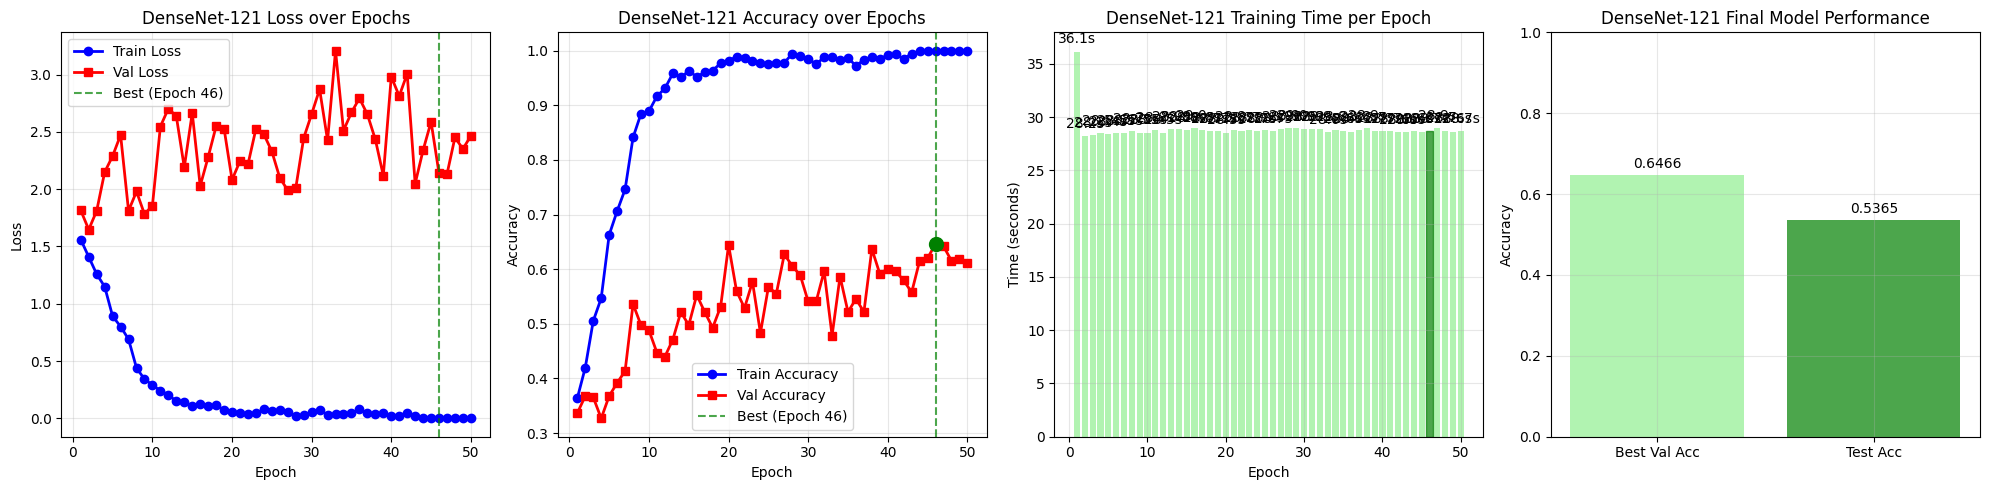


⏰ DenseNet-121 Final Timing Summary:
│ Total Training: 1442.13s
│ Average per Epoch: 28.84s
│ Testing Time: 6.49s
│ Total Runtime: 1448.61s

💾 DenseNet-121 Files saved:
│ best_densenet121_model.pth - Best validation accuracy model
│ densenet121_training_history.csv - Training metrics for later plotting


In [8]:
# -----------------------------
# 4. Training Loop with Best Model Saving (Val Accuracy) - DenseNet-121
# -----------------------------
import pandas as pd
from tqdm import tqdm
import time

train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking - CHANGED TO VAL_ACC
best_val_acc = 0.0  # Changed from best_val_loss = float('inf')
best_model_state = None
best_epoch = 0

print(f"\n🚀 Starting DenseNet-121 Training for {epochs} epochs...")
print("=" * 80)
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc=f"Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc=f"Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model so far based on val_acc - CHANGED
    is_best = val_acc > best_val_acc  # Changed from val_loss < best_val_loss
    if is_best:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best DenseNet-121 model found! Validation Accuracy: {val_acc:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch})")  # Changed
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model - UPDATED MESSAGES
if best_model_state is not None:
    torch.save(best_model_state, 'best_densenet121_model.pth')
    print(f"\n💾 Best DenseNet-121 model saved as 'best_densenet121_model.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")  # Changed from best_val_loss

# NEW: Save training history data to CSV
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}
history_df = pd.DataFrame(history_data)
history_df.to_csv('densenet121_training_history.csv', index=False)
print("\n💾 DenseNet-121 training history saved to 'densenet121_training_history.csv'")

# Training Summary
print(f"\n🎉 DenseNet-121 Training Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")
print("\n⏱️  Epoch Timing Breakdown:")
for i, t in enumerate(epoch_times):
    print(f"│ Epoch {i+1}: {t:.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best DenseNet-121 Model for Testing...")
# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best DenseNet-121 model from epoch {best_epoch} loaded successfully!")
else:
    print("⚠️  No best model found, using current model state")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()

test_pbar = tqdm(test_loader, desc="Testing DenseNet-121", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ DenseNet-121 Testing completed in {test_time:.2f}s")
print("\n📋 DenseNet-121 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"🎯 DenseNet-121 Test Accuracy: {test_accuracy:.4f}")

# Model Performance Summary - UPDATED
print(f"\n📊 DenseNet-121 Model Performance Summary:")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")  # Changed
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"DenseNet-121 Confusion Matrix - Best Model (Epoch {best_epoch})")
plt.show()

# -----------------------------
# 6. Enhanced Visualizations - UPDATED
# -----------------------------
plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 4, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.legend()
plt.title("DenseNet-121 Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot - UPDATED
plt.subplot(1, 4, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='green', s=100, zorder=5)  # Changed to best_val_acc
plt.legend()
plt.title("DenseNet-121 Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Timing Plot
plt.subplot(1, 4, 3)
bars = plt.bar(range(1, epochs+1), epoch_times, color='lightgreen', alpha=0.7)
bars[best_epoch-1].set_color('green')
plt.title("DenseNet-121 Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)
for i, t in enumerate(epoch_times):
    plt.text(i+1, t+0.5, f'{t:.1f}s', ha='center', va='bottom')

# Performance Comparison
plt.subplot(1, 4, 4)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['lightgreen', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("DenseNet-121 Final Model Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n⏰ DenseNet-121 Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

print(f"\n💾 DenseNet-121 Files saved:")
print(f"│ best_densenet121_model.pth - Best validation accuracy model")
print(f"│ densenet121_training_history.csv - Training metrics for later plotting")

In [9]:
import pandas as pd
df=pd.read_csv("/kaggle/working/densenet121_training_history.csv")
df

,epoch,train_loss,val_loss,train_acc,val_acc,epoch_time
0,1,1.560222,1.814160,0.363932,0.336538,36.138387
1,2,1.408877,1.647199,0.419922,0.367788,28.178643
2,3,1.258419,1.811282,0.505208,0.365385,28.284655
3,4,1.149581,2.148065,0.546875,0.326923,28.478535
4,5,0.891296,2.288893,0.662760,0.367788,28.421212
5,6,0.801597,2.472557,0.706380,0.391827,28.495896
6,7,0.690367,1.810679,0.746094,0.413462,28.510274
7,8,0.439597,1.979546,0.841146,0.536058,28.678919
8,9,0.342839,1.781757,0.884766,0.497596,28.530587
9,10,0.290925,1.857198,0.889323,0.487981,28.535145
